In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from xml.etree import ElementTree as ET

plt.style.use('ggplot')

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Background

My wife and I have recently started to consider what life might look like after New York City. She's been here 15 years and I've been here 10 and we both agree that it's time for a change. One of the cities at the top of our list is Denver, Colorado and one of the appealing features of the city is that, unlike New York, we could afford to buy a house there. This got me thinking--how can I use data science to learn more about the real estate situation in Denver? 

Fortunately for me, Denver has a great open data catalog: https://www.denvergov.org/opendata/. One of the datasets available is [Real Property Sales and Transfers](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-real-property-sales-and-transfers) which contains all records of property ownership transfers from 2008 to the present. What luck! A second dataset titled [Real Property Residential Characteristics](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-real-property-residential-characteristics) will be used to add additional information such as number of bedrooms and square footage to my analysis.

## Importing the dataset

The Real Property Sales and Transfers dataset includes records of all sales and transfers of property in Denver. Fortunately for me, it's in relatively good shape and doesn't need too much work to clean.

In [3]:
df_sales = pd.read_csv('datasets/real_property_sales_and_transfers.csv')

C:\Users\Trent\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
sales_dict = pd.read_excel('datasets/RealPropertyMetaData.xlsx', sheetname='Sales_Transfers', header=3, parse_cols=[1,2,3,5])
sales_dict

,Field Name,Example,Column Type,Description
0,PIN,163752899,Text,Assessor's Property Identification Number
1,SCHEDNUM,0231416005000,Text,Assessor's Schedule Number
2,RECEPTION_NUM,2011148564,Text,Clerk & Recorder's Reception Number
3,RECEPTION_DATE,20101004,Text,Clerk & Recorder's Reception Date
4,INSTRUMENT,WD,Text,Type of Instrument
5,SALE_YEAR,2010,Text,Sale Year
6,SALE_MONTHDAY,0928,Text,Sale Month/Day
7,SALE_PRICE,199677,Text,Sale Price
8,GRANTOR,"SMITH, JOHN & JANE",Text,Person(s) relinquishing ownership
9,GRANTEE,"BROWN, JAMES",Text,Person(s) recieving ownership


In [5]:
df_sales.head()

,SCHEDNUM,RECEPTION_NUM,INSTRUMENT,SALE_YEAR,SALE_MONTHDAY,RECEPTION_DATE,SALE_PRICE,GRANTOR,GRANTEE,CLASS,MKT_CLUS,D_CLASS,D_CLASS_CN,NBHD_1,NBHD_1_CN,PIN
0,3100025000,2015007009,WD,2015,120,20150121,9350000.000,PEP LENOCH DENVER V LLC &,MENIFEE MART INC,C,nan,22M,MIXED USE-HOTEL/RESD,4,GATEWAY N,163547560
1,3100028000,2014036460,WD,2014,331,20140402,7900000.000,SMITA MERCHANT INC,S&RN MANAGEMENT INC,C,nan,28T,MISC IMPS-TIE BACK,4,GATEWAY N,163556381
2,3100028000,2011125634,WD,2011,1102,20111104,5400000.000,CAMPBELL HOLDINGS,SMITA MERCHANT INC,C,nan,28T,MISC IMPS-TIE BACK,4,GATEWAY N,163556381
3,3100036000,2009028420,PS,2009,304,20090306,nan,CORPOREX HIGH POINT LLC,CORPOREX HIGH POINT LLC,A,nan,022,VCNT LAND BA-2 ZONE,4,GATEWAY N,163596315
4,3100037000,2009028420,PS,2009,304,20090306,nan,CORPOREX HIGH POINT LLC,CORPOREX HIGH POINT LLC,C,nan,223,HOTEL - RESIDENCE/SUITE,4,GATEWAY N,163596323


In [6]:
df_sales.describe()

,SCHEDNUM,SALE_YEAR,SALE_MONTHDAY,RECEPTION_DATE,SALE_PRICE,MKT_CLUS,NBHD_1,PIN
count,234824.000,234824.000,234824.000,234824.000,165431.000,224029.000,234824.000,234824.000
mean,387336752194.890,2011.918,662.937,20120316.570,592534.596,25.768,398.547,162054260.713
std,223869952158.367,2.561,330.008,48541.241,4082154.598,17.092,235.559,1099712.526
min,3100025000.000,2008.000,101.000,130328.000,1.000,0.000,1.000,160088986.000
25%,220331003750.000,2010.000,409.000,20100325.000,98000.000,11.000,215.000,161130939.250
50%,503409046046.000,2012.000,628.000,20120821.000,225000.000,23.000,512.000,161810948.000
75%,527511015000.000,2014.000,923.000,20140922.000,398000.000,41.000,588.000,163099534.250
max,915401173173.000,2016.000,1231.000,20160909.000,387500000.000,56.000,906.000,164097228.000


## Filtering the dataset to only show single family home sales

All property types are included in this dataset, but I'm not interested in commercial properties or apartments, so I'm going to filter all of those out and only keep the records of single family homes.

In [7]:
single_family_home = 'SINGLE FAMILY'

df_sales = df_sales[df_sales.D_CLASS_CN == single_family_home]
df_sales.shape

(139043, 16)

I'm also going to remove any records that have a sale price less than \$100,000 and more than \$600,000. Anything with a sale price less than \$50,000 indicates to me that there are some issues with the data and anything over \$600,000 is way out of my range. The next plot shows that while the number of home sales has fluctuated from year to year, the mean sale price has consistently gone up since 2009.

In [8]:
df_sales = df_sales[(df_sales.SALE_PRICE > 100000) & (df_sales.SALE_PRICE < 500000)]
df_sales.shape

(58615, 16)

That leaves me with just under 64,000 records to work with.

A quick look at the number of home sales and transfers each year shows that 2013 and 2014 were the biggest years in the dataset in terms of volume. The volume in 2015 decreased slightly. 

_Note: The dip in 2016 sales and transfers can be attributed to incomplete data since the year isn't complete._

In [9]:
yearly_sales = df_sales.groupby('SALE_YEAR').size()

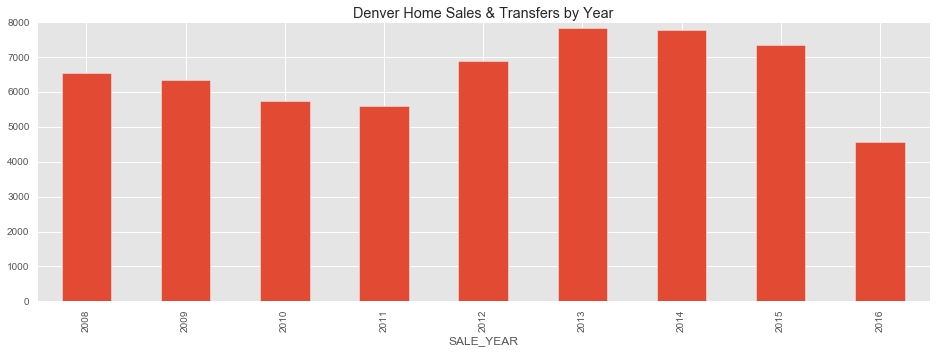

In [10]:
df_sales.groupby('SALE_YEAR').size().plot('bar', 
                                          figsize=(16, 5),
                                          title= "Denver Home Sales & Transfers by Year");

While the number of sales in 2015 was less than 2013 and 2014, the mean sale price of homes has consistently moved upwards since 2009.

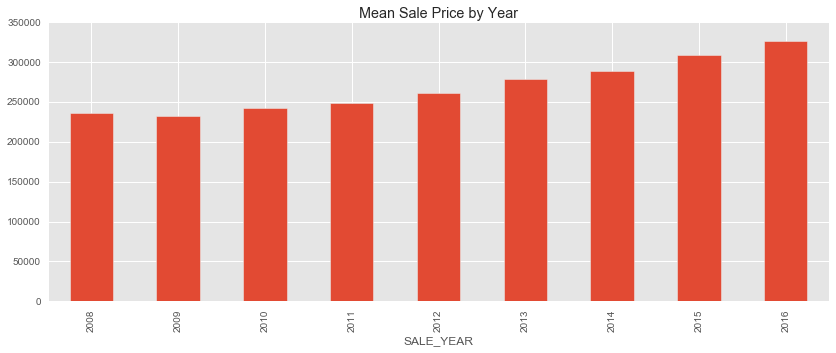

In [11]:
df_sales.groupby('SALE_YEAR')['SALE_PRICE'].mean().plot('bar', figsize=(14,5), title="Mean Sale Price by Year");

Homes seem to be getting more expensive. Not great for me.

Obviously, we want to find the right neighborhood, but we're not sure what that even means yet. As a starting point, I want to know what neighborhoods had the most sales and transfers. Plotting the neighborhoods with the highest mean sale price will tell me which neighborhoods I can't afford.

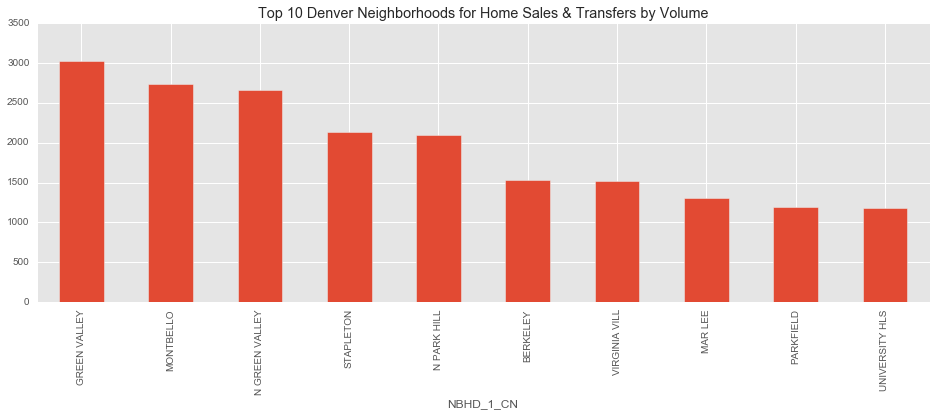

In [12]:
df_sales.groupby('NBHD_1_CN').size().sort_values(ascending=False).head(10).plot('bar', 
                                          figsize=(16, 5),
                                          title= "Top 10 Denver Neighborhoods for Home Sales & Transfers by Volume");

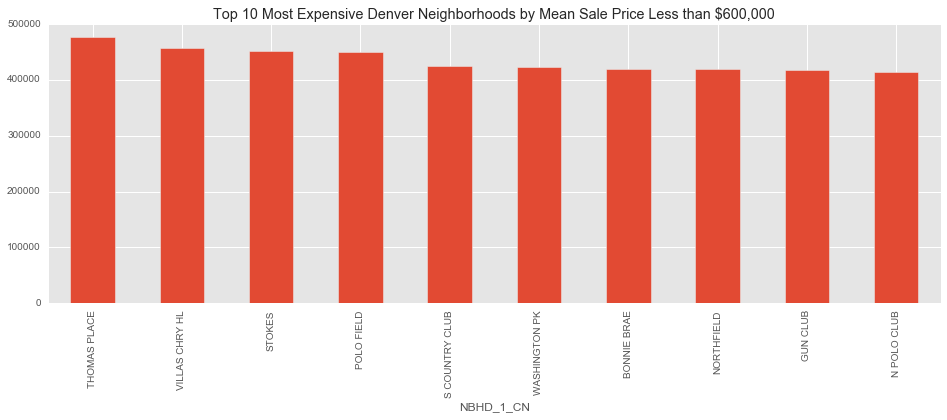

In [13]:
df_sales.groupby('NBHD_1_CN')['SALE_PRICE'].mean().sort_values(ascending=False).head(10).plot('bar', 
                                          figsize=(16, 5),
                                          title= "Top 10 Most Expensive Denver Neighborhoods by Mean Sale Price Less than $600,000");

## Adding datetime and setting it as the index

It would also be interesting to dig a little deeper into the trends that might exist in sales and transfers over time. In order to do this, I'll need to convert the SALE_YEAR and SALE_MONTHDAY columns into a new column with datetime formatting. 

In [14]:
days = []
months = []
years = df_sales.SALE_YEAR.astype(str)
datetimes = []

for row in df_sales.SALE_MONTHDAY:
    row = str(row)
    if len(row) < 4:
        row = '0' + row
    days.append(row[:-2])
    months.append(row[2:])
    
df_sales['date'] = years + '-' + months + '-' + days

df_sales['date'] = pd.to_datetime(df_sales['date'], format='%Y-%d-%m')

df_sales.index = df_sales.date

df_sales['year'] = df_sales.index.year
df_sales['month'] = df_sales.index.month
df_sales['day'] = df_sales.index.day

In [15]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sales_2013 = df_sales['2013']['SALE_PRICE'].resample('M', how='count')
sales_2014 = df_sales['2014']['SALE_PRICE'].resample('M', how='count')
sales_2015 = df_sales['2015']['SALE_PRICE'].resample('M', how='count')
sales_2016 = df_sales['2016']['SALE_PRICE'].resample('M', how='count')

monthly_df = pd.DataFrame({'Month': months,
                           '2013' : sales_2013.values,
                           '2014' : sales_2014.values,
                           '2015' : sales_2015.values})

C:\Users\Trent\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  from ipykernel import kernelapp as app
C:\Users\Trent\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  app.launch_new_instance()
C:\Users\Trent\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
C:\Users\Trent\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()


In [16]:
monthly_df.index = monthly_df.Month

### Monthly Sales Comparison

Looking at monthly sales for both 2014 and 2015 clearly shows that there are seasonal trends in home sales and transfers.

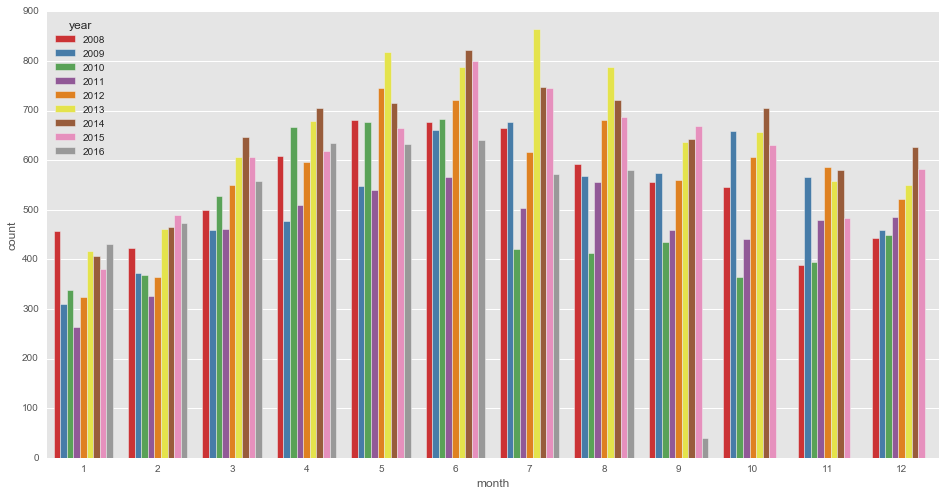

In [17]:
fig = plt.figure(figsize=(16,8))
ax = sns.countplot(x="month", hue="year", data=df_sales, palette="Set1")

plt.show()

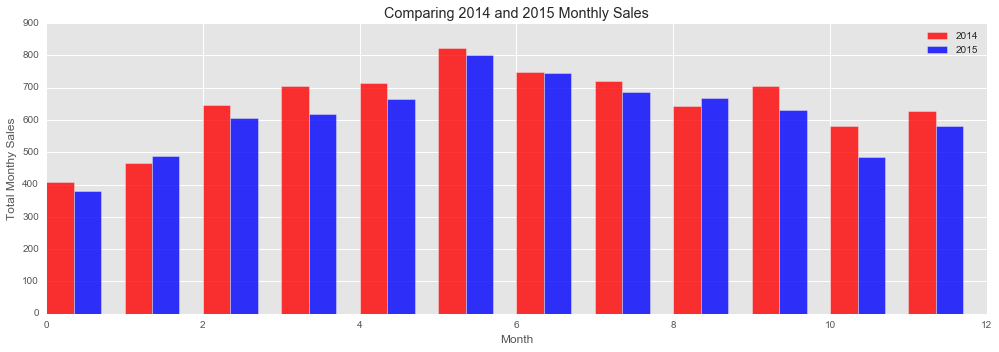

In [18]:
# data to plot
n_groups = 12

# create plot
fig, ax = plt.subplots(figsize=(14,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, monthly_df['2014'], bar_width,
                 alpha=opacity,
                 color='r',
                 label='2014')
 
rects2 = plt.bar(index + bar_width, monthly_df['2015'], bar_width,
                 alpha=opacity,
                 color='b',
                 label='2015')
 
plt.xlabel('Month')
plt.ylabel('Total Monthy Sales')
plt.title('Comparing 2014 and 2015 Monthly Sales')
plt.legend()
 
plt.tight_layout()
plt.show()

## Importing Property Characteristics dataset

Now, let's add in the Real Property Residential Characteristics dataset. It contains information about each home such as number of bedrooms and square footage. For an initial look at the data, let's see how square footage and sale price are related.

In [19]:
df_characteristics = pd.read_csv('datasets/real_property_residential_characteristics.csv', usecols=['PIN',
                                                                                          'LAND_SQFT',
                                                                                          'AREA_ABG',
                                                                                          'BSMT_AREA', 
                                                                                          'FBSMT_SQFT',
                                                                                          'GRD_AREA',
                                                                                          'BED_RMS',
                                                                                          'FULL_B',
                                                                                          'HLF_B',
                                                                                          'STYLE_CN',
                                                                                          'STORY',
                                                                                          'CCYRBLT',
                                                                                          'CCAGE_RM',
                                                                                          'ASMT_APPR_LAND',
                                                                                          'TOTAL_VALUE',
                                                                                          'ASDLAND',
                                                                                          'ASSESS_VALUE',
                                                                                          'ASMT_TAXABLE',
                                                                                          'ASMT_EXEMPT_AMT',
                                                                                          'LEGL_DESCRIPTION'], 
                                                                                          error_bad_lines=False)

Skipping line 63332: expected 46 fields, saw 47
Skipping line 63335: expected 46 fields, saw 47
Skipping line 63338: expected 46 fields, saw 47

Skipping line 68348: expected 46 fields, saw 48
Skipping line 69469: expected 46 fields, saw 47
Skipping line 69470: expected 46 fields, saw 47
Skipping line 69471: expected 46 fields, saw 47
Skipping line 69472: expected 46 fields, saw 47



In [20]:
df_full_info = df_sales.merge(df_characteristics, how='left', on='PIN')
df_full_info.dropna(inplace=True)

### df_characteristics Data Dictionary

In [21]:
characteristics_dict = pd.read_excel('datasets/RealPropertyMetaData.xlsx', 
                                     sheetname='Residential_Characteristics', 
                                     header=3, 
                                     parse_cols=[1,2,3,5],
                                     skiprows=[5,6,7,8,9,10,11,12,13,14,15,16, 17,18,19,20,21,22,23,24,25,26,27,40])
characteristics_dict

,Field Name,Example,Column Type,Description
0,PIN,161714761,Text,Assessor's Property Identification Number
1,LAND_SQFT,6241,Long Integer,Land Area
2,AREA_ABG,1411,Long Integer,Above Grade Improvement Area
3,BSMT_AREA,389,Long Integer,Basement Square Footage
4,FBSMT_SQFT,389,Long Integer,Finished Basement Area
5,GRD_AREA,0,Long Integer,Garden Level Square Footage
6,STORY,1,Float,Stories
7,STYLE_CN,TWO-STORY,Text,Architecture Style Code Definition
8,BED_RMS,3,Short Integer,Number of bedroom above grade
9,FULL_B,2,Short Integer,Total number of full baths


### Looking at Distributions of Some of the Features

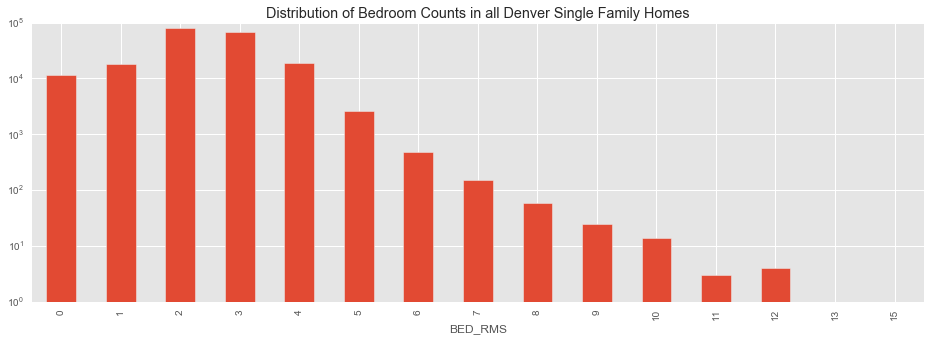

In [22]:
df_characteristics.groupby('BED_RMS').size().plot(kind='bar', figsize=(16,5), 
                                                  title='Distribution of Bedroom Counts in all Denver Single Family Homes', 
                                                  logy=True);

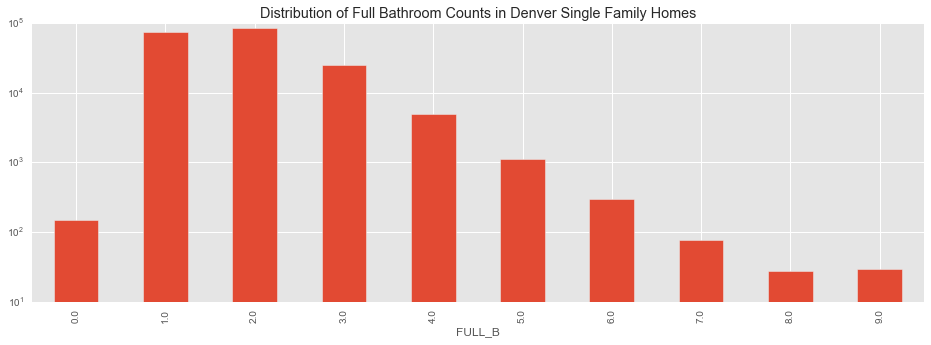

In [23]:
df_characteristics.groupby('FULL_B').size().plot(kind='bar', figsize=(16,5), 
                                                 title='Distribution of Full Bathroom Counts in Denver Single Family Homes', 
                                                  logy=True);

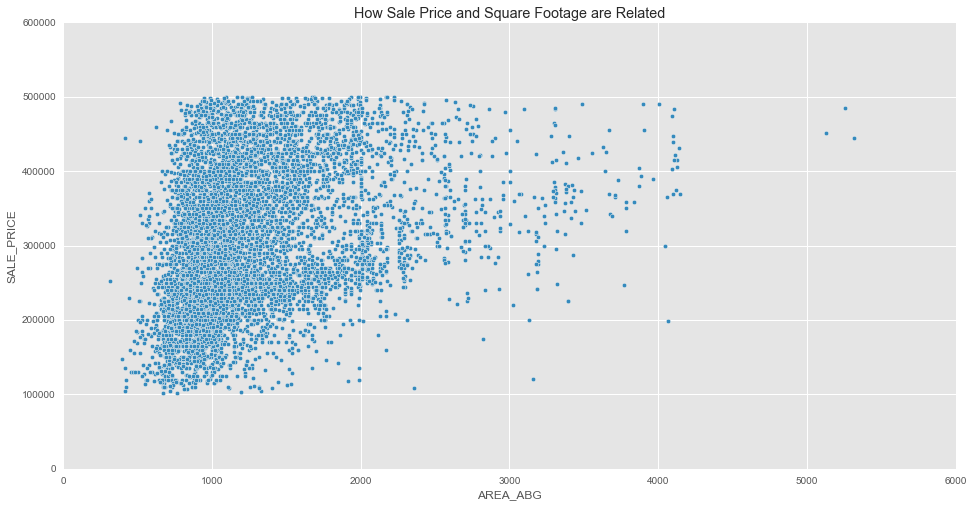

In [261]:
df_full_info[df_full_info.year == 2015].plot(x='AREA_ABG', 
                                             y='SALE_PRICE', 
                                             kind='scatter', 
                                             figsize=(16, 8), 
                                             xlim=(0, 6000),
                                             ylim=(0, 600000),
                                             title="How Sale Price and Square Footage are Related");

This visualization shows what I would expect--higher square footage correlates with a higher sale price. The gap in the middle of the homes makes me think there might be two or more different clusters in the data.

In [25]:
df_pairplot = df_full_info[['SALE_PRICE', 'LAND_SQFT', 'AREA_ABG', 'ASSESS_VALUE', 'ASMT_TAXABLE']].dropna()

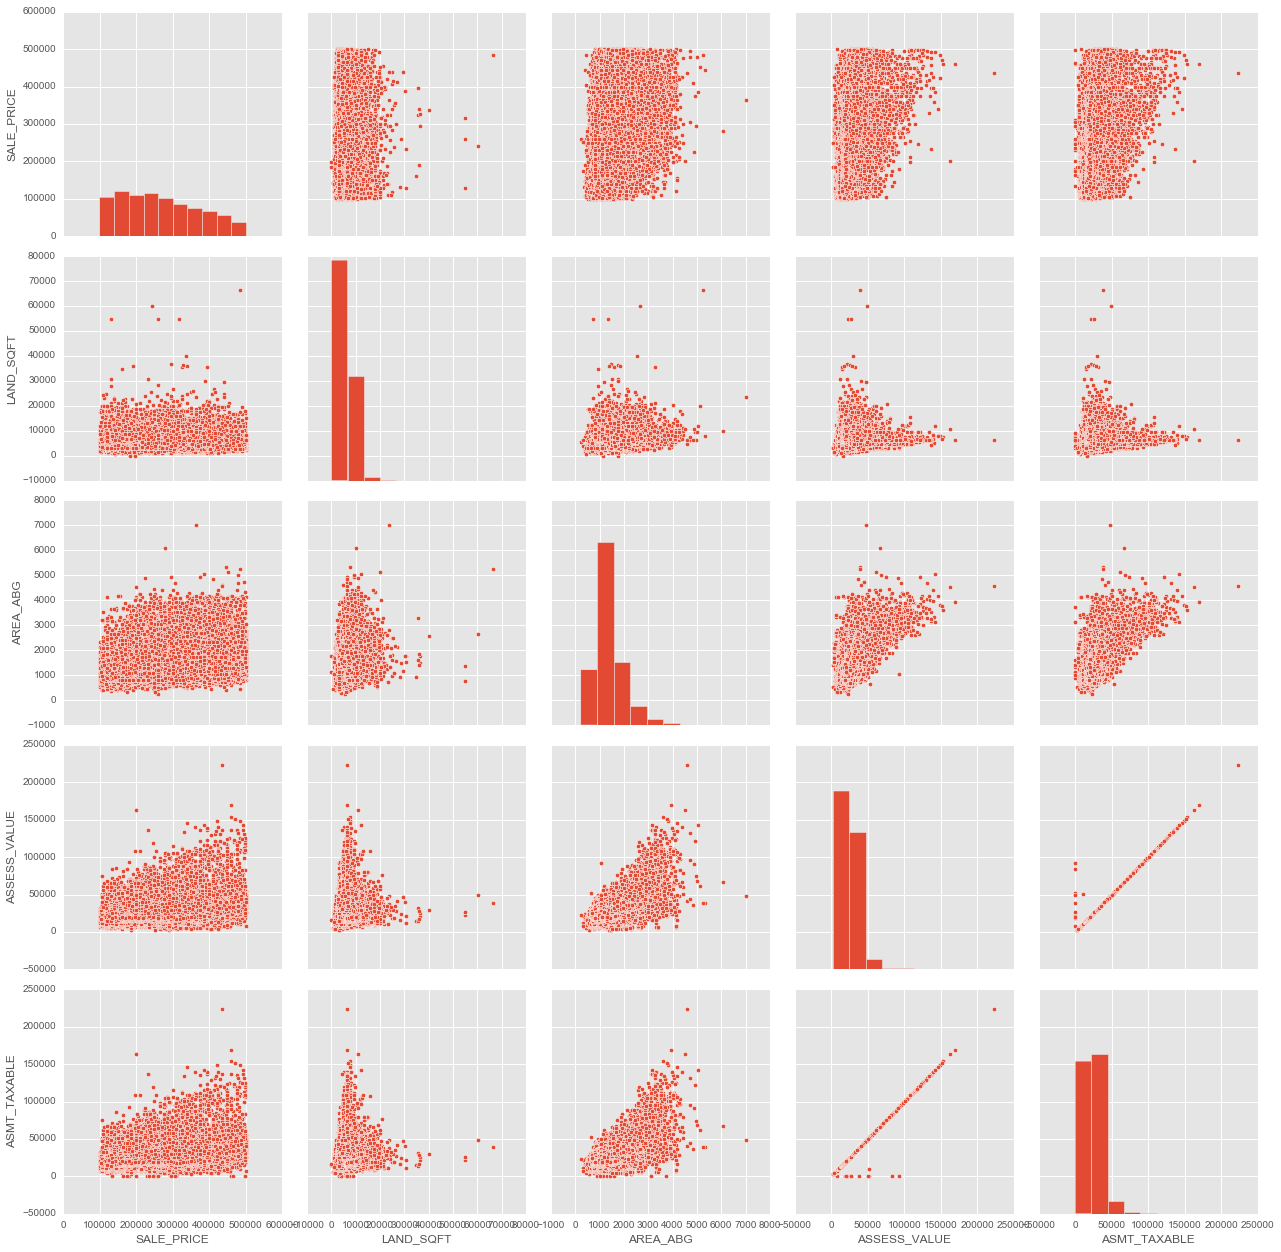

In [26]:
sns.pairplot(df_pairplot, size=3.5);

Looking at the pairplot above and then _df\_pairplot.describe()_ shows that there are some records that have zero as a value for _LAND\_SQFT_, _AREA\_ABG_, and _BED\_RMS_. I'll be looking into that in the near future. AREA_ABG and both ASSESS_VALUE and ASMT_TAXABLE have the positive correlation I would expect. It's also not a surprise that ASSESS_VALUE and ASMT_TAXABLE draw a nearly perfect 45 degree line. I'll need to drop one of those columns before running a regression.

The relationship of SALE_PRICE and all of the other variables is mostly unclear. At the lower end of each of the variables, there appears to be no discernable pattern.

### Feature Correlations

In preparation for the regression I will be modelling with this data, let's take a look at the variables to see if there might be any obvious correlation issues.

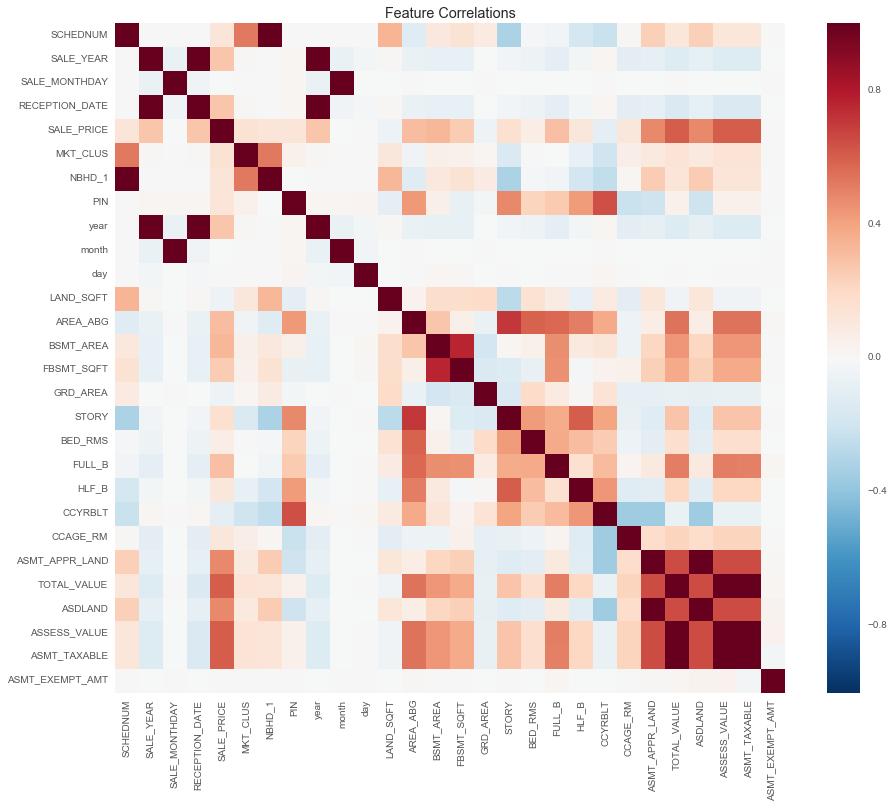

In [27]:
plt.figure(figsize=(15,12))
ax = sns.heatmap(df_full_info.corr())
plt.title("Feature Correlations")

plt.show()

Yes. There some features will need to be dropped in order to avoid problems due to high correlation.

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In this step I'm going to separate the feature variables from the outcome variable.

In [29]:
all_features = df_full_info.drop('SALE_PRICE', axis=1)
numerical_features = all_features.select_dtypes(exclude=['object', 'datetime64'])

X_features = numerical_features.dropna()
y = df_full_info['SALE_PRICE']

In [30]:
numerical_features.columns

Index([u'SCHEDNUM', u'SALE_YEAR', u'SALE_MONTHDAY', u'RECEPTION_DATE',
       u'MKT_CLUS', u'NBHD_1', u'PIN', u'year', u'month', u'day', u'LAND_SQFT',
       u'AREA_ABG', u'BSMT_AREA', u'FBSMT_SQFT', u'GRD_AREA', u'STORY',
       u'BED_RMS', u'FULL_B', u'HLF_B', u'CCYRBLT', u'CCAGE_RM',
       u'ASMT_APPR_LAND', u'TOTAL_VALUE', u'ASDLAND', u'ASSESS_VALUE',
       u'ASMT_TAXABLE', u'ASMT_EXEMPT_AMT'],
      dtype='object')

Now I need to create dummy variables for my year, month, and day columns.

In [276]:
month_dummies = pd.get_dummies(df_full_info.month, prefix='month', drop_first=True)
nbhd_dummies = pd.get_dummies(df_full_info.NBHD_1_CN, prefix = 'nbhd', drop_first=True)
story_dummies = pd.get_dummies(df_full_info.STORY, prefix = 'story', drop_first=True)

In [424]:
features = ['AREA_ABG', 'BSMT_AREA', 'ASMT_TAXABLE', 'GRD_AREA', 'CCYRBLT', 'year', 'LAND_SQFT', 'FBSMT_SQFT', 'BED_RMS', 'FULL_B', 'HLF_B', 'CCAGE_RM']

X = X_features[features]
X = pd.concat([X, month_dummies, nbhd_dummies, story_dummies], axis=1)

Now I'm going to set up a training set and validation set. All of the model testing will happen only on the training set and I'll save the validation set for the very end of the project to perform the final evaluation of the model.

In [425]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=.33, random_state=42)

The first model I'm going to run on the data is a linear regression. First I'll split the data into training and testing sets. Then I'll run a 10 fold cross-validation on the training set.

In [365]:
X_train.head()

,AREA_ABG,BSMT_AREA,ASMT_TAXABLE,ASMT_EXEMPT_AMT,ASSESS_VALUE,GRD_AREA,CCYRBLT,year,LAND_SQFT,FBSMT_SQFT,BED_RMS,FULL_B,HLF_B,CCAGE_RM,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,nbhd_ARAPAHOE SQUARE,nbhd_ATHMAR PARK,nbhd_AVONDALE,nbhd_BAKER,nbhd_BARNUM,nbhd_BEAR VALLEY,nbhd_BELCARO,nbhd_BELMONT HTS,nbhd_BERKELEY,nbhd_BISCAYNE,nbhd_BONNIE BRAE,nbhd_BREAKERS,nbhd_CAPITOL HILL,nbhd_CAPITOL HILL S,nbhd_CENTRAL PARK,nbhd_CHAFFEE PARK,nbhd_CHEESMAN PARK,nbhd_CHERMONT,nbhd_CHERRY CREEK,nbhd_CHERRY POINT,nbhd_CLAYTON,nbhd_COLE,nbhd_COLLEGE VIEW,nbhd_CONGRESS PARK,nbhd_CORNERSTONE,nbhd_CORY MERRILL,nbhd_COUNTRY CLUB,nbhd_CREEKVW/SUNSET,nbhd_CRESTMOOR,nbhd_CRESTMOOR E,nbhd_CRESTRIDGE,nbhd_CURTIS PARK,nbhd_DARTMOUTH HTS,nbhd_E COLFAX (N),nbhd_E COLFAX (S),nbhd_E HARVEY PARK,nbhd_E HIGHLAND,nbhd_E SLOANS LAKE,nbhd_EAST BAY,nbhd_FIVE POINTS,nbhd_FORT LOGAN,nbhd_GLENBROOK,nbhd_GLOBEVILLE,nbhd_GODSMAN,nbhd_GOLDSMITH,nbhd_GOLDSMITH W,nbhd_GRANT RN/MARST,nbhd_GREEN VALLEY,nbhd_GUN CLUB,nbhd_HALE/MAYFAIR,nbhd_HAMPDEN HTS E,nbhd_HAMPDEN HTS W,nbhd_HARVEY PARK,nbhd_HIGHLAND,nbhd_HILLTOP,nbhd_HILLTOP 6TH AV,nbhd_HILLTOP DOWNS,nbhd_HOLLY HILLS,nbhd_HOLLY RIDGE,nbhd_HUTCH/WILLOW P,nbhd_HUTCHINSON HLS,nbhd_INDIAN CREEK,nbhd_INSPIRATION PT,nbhd_JEFFERSON PARK,nbhd_LINCOLN PARK,nbhd_LOWRY,nbhd_LYNWOOD,nbhd_MAR LEE,nbhd_MONACO PKWY,nbhd_MONTBELLO,nbhd_MONTCLAIR,nbhd_N CAPITOL HILL,nbhd_N CHERRY CREEK,nbhd_N CONGRESS PK,nbhd_N COUNTRY CLUB,nbhd_N GREEN VALLEY,nbhd_N PARK HILL,nbhd_N POLO CLUB,nbhd_N SLOANS LAKE,nbhd_N SPEER,nbhd_N UNIVERSITY,nbhd_NE PARK HILL,nbhd_NORTHFIELD,nbhd_OVERLAND,nbhd_OVERLOOK,nbhd_PARK FOREST,nbhd_PARK HILL (N),nbhd_PARK HILL (S),nbhd_PARK VISTA,nbhd_PARKFIELD,nbhd_PARKWAY,nbhd_PARKWEST,nbhd_PINE RIDGE,nbhd_PINE VALLEY,nbhd_PINECREST,nbhd_PINEHURST,nbhd_PINEHURST ES S,nbhd_PINEHURST ESTA,nbhd_PLATTE PARK,nbhd_POLO FIELD,nbhd_POPLAR COVE,nbhd_RANGE VIEW,nbhd_REGIS,nbhd_RIVER NORTH,nbhd_ROSEDALE,nbhd_RUBY HILL,nbhd_S CHERRY CREEK,nbhd_S CITY PARK,nbhd_S COUNTRY CLUB,nbhd_S HALE,nbhd_S HARVEY PARK,nbhd_S SPEER,nbhd_S WASHINGTON PK,nbhd_S. HILLTOP,nbhd_SEVEN SPRINGS,nbhd_SKYLAND,nbhd_SLOANS LAKE,nbhd_SOUTHMOOR #1,nbhd_SOUTHMOOR PARK,nbhd_STAPLETON,nbhd_STOKES,nbhd_SUMMERFIELD,nbhd_SUN VALLEY,nbhd_SUNNYSIDE,nbhd_SWANSEA,nbhd_SWANSEA (N),nbhd_SWANSEA (S),nbhd_TAMARAC HILLS,nbhd_THOMAS PLACE,nbhd_UNIVERSITY,nbhd_UNIVERSITY HLS,nbhd_UNIVERSITY PK,nbhd_UNIVERSITY S,nbhd_VALVERDE,nbhd_VILLA PARK,nbhd_VILLAS CHRY HL,nbhd_VIRGINIA VALE,nbhd_VIRGINIA VILL,nbhd_W BAKER,nbhd_W CITY PARK,nbhd_W COLFAX,nbhd_W HIGHLAND,nbhd_W HIGHLAND / HGV,nbhd_W WASHINGTON PARK,nbhd_W WASHINGTON PK,nbhd_WASHINGTON,nbhd_WASHINGTON PK,nbhd_WELLSHIRE EAST,nbhd_WESTBRIDGE,nbhd_WESTWOOD,nbhd_WHITTIER,nbhd_WILLOW POINT E,nbhd_WLSHR/S HILLS,nbhd_ZUNI PARK,story_1.5,story_2.0,story_2.5,story_3.0
44206,763.000,0.000,10370.000,0.000,10364.000,0.000,1943.000,2016,8850.000,0.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
44326,1308.000,0.000,14280.0

In [366]:
y_true = []
y_pred = []

folds = KFold(y_train.size, n_folds=10, random_state=42)

for train, test in folds:
    model = LinearRegression()
    model.fit(X_train.iloc[train], y_train.iloc[train])
    
    [y_true.append(result) for result in y_train.iloc[test]]
    [y_pred.append(result) for result in model.predict(X_train.iloc[test])] 

    rsme = np.sqrt(mean_squared_error(y_true, y_pred))   
    
print "Root Mean Squared Error: ", rsme

Root Mean Squared Error:  61288.4807455


Not great, but it's a starting point.

Since I'll be running this model frequently, I'll put the model into a function.

In [390]:
def linear_model(X, y, n_folds=4, random_state=42):
    y_train_true = []
    y_train_pred = []
    y_test_true = []
    y_test_pred = []

    folds = KFold(y.size, n_folds=n_folds, random_state=42)

    for train, test in folds:
        model = LinearRegression()
        model.fit(X.iloc[train], y.iloc[train])
        
        [y_train_true.append(t) for t in y.iloc[train]]
        [y_train_pred.append(t) for t in model.predict(X.iloc[train])]
        [y_test_true.append(result) for result in y.iloc[test]]
        [y_test_pred.append(result) for result in model.predict(X.iloc[test])] 
    
    rsquared_train = metrics.r2_score(y_train_true, y_train_pred)
    rsquared_test  = metrics.r2_score(y_test_true, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))   
    
    return pd.DataFrame({
            "R^2 Train": rsquared_train, 
            "R^2 Test": rsquared_test, 
            "Root Mean Squared Error": rmse
        }, index=[model.__class__.__name__])

In [391]:
linear_model(X_train, y_train)

,R^2 Test,R^2 Train,Root Mean Squared Error
LinearRegression,0.658,0.664,61716.762


Time for an alternate model! Adjustments to my linear regression model aren't making strong gains, so I'm going to use a random forest model in an attempt for better results.

In [369]:
from sklearn.ensemble import RandomForestRegressor

In [426]:
def forest_model(X, y, max_features=140, 
                       max_depth=30,
                       test_size=.33, 
                       n_folds=4, 
                       min_samples_split=25,
                       min_samples_leaf=3,
                       random_state=42):
    y_train_true = []
    y_train_pred = []
    y_test_true = []
    y_test_pred = []
    
    folds = KFold(y.size, n_folds=n_folds, random_state=random_state)

    for train, test in folds:
        forest = RandomForestRegressor(max_features=max_features, 
                                       max_depth=max_depth, 
                                       random_state=random_state,
                                       min_samples_split=min_samples_split, 
                                       min_samples_leaf=min_samples_leaf)
        forest.fit(X.iloc[train], y.iloc[train])
        
        [y_train_true.append(t) for t in y.iloc[train]]
        [y_train_pred.append(t) for t in forest.predict(X.iloc[train])]
        [y_test_true.append(result) for result in y.iloc[test]]
        [y_test_pred.append(result) for result in forest.predict(X.iloc[test])]
    
    rsquared_train = metrics.r2_score(y_train_true, y_train_pred)
    rsquared_test  = metrics.r2_score(y_test_true, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))   
    
    return pd.DataFrame({
            "R^2 Train": rsquared_train, 
            "R^2 Test": rsquared_test, 
            "Root Mean Squared Error": rmse
        }, index=[forest.__class__.__name__])

In [427]:
forest_model(X_train, y_train)

,R^2 Test,R^2 Train,Root Mean Squared Error
RandomForestRegressor,0.781,0.868,49392.730


### Adding K-Means Clustering

I'm going to use K-Means clustering to try and improve my model.

In [41]:
from sklearn import cluster

In [433]:
kmeans = cluster.KMeans(n_clusters=8, n_init=10)
cluster_predictions = kmeans.fit_predict(df_full_info[features])
df_full_info['cluster'] = cluster_predictions

In [434]:
df_full_info.cluster.value_counts()

3    13560
1    13276
4    11290
6    10481
0     6708
5     2281
7      753
2      239
Name: cluster, dtype: int64

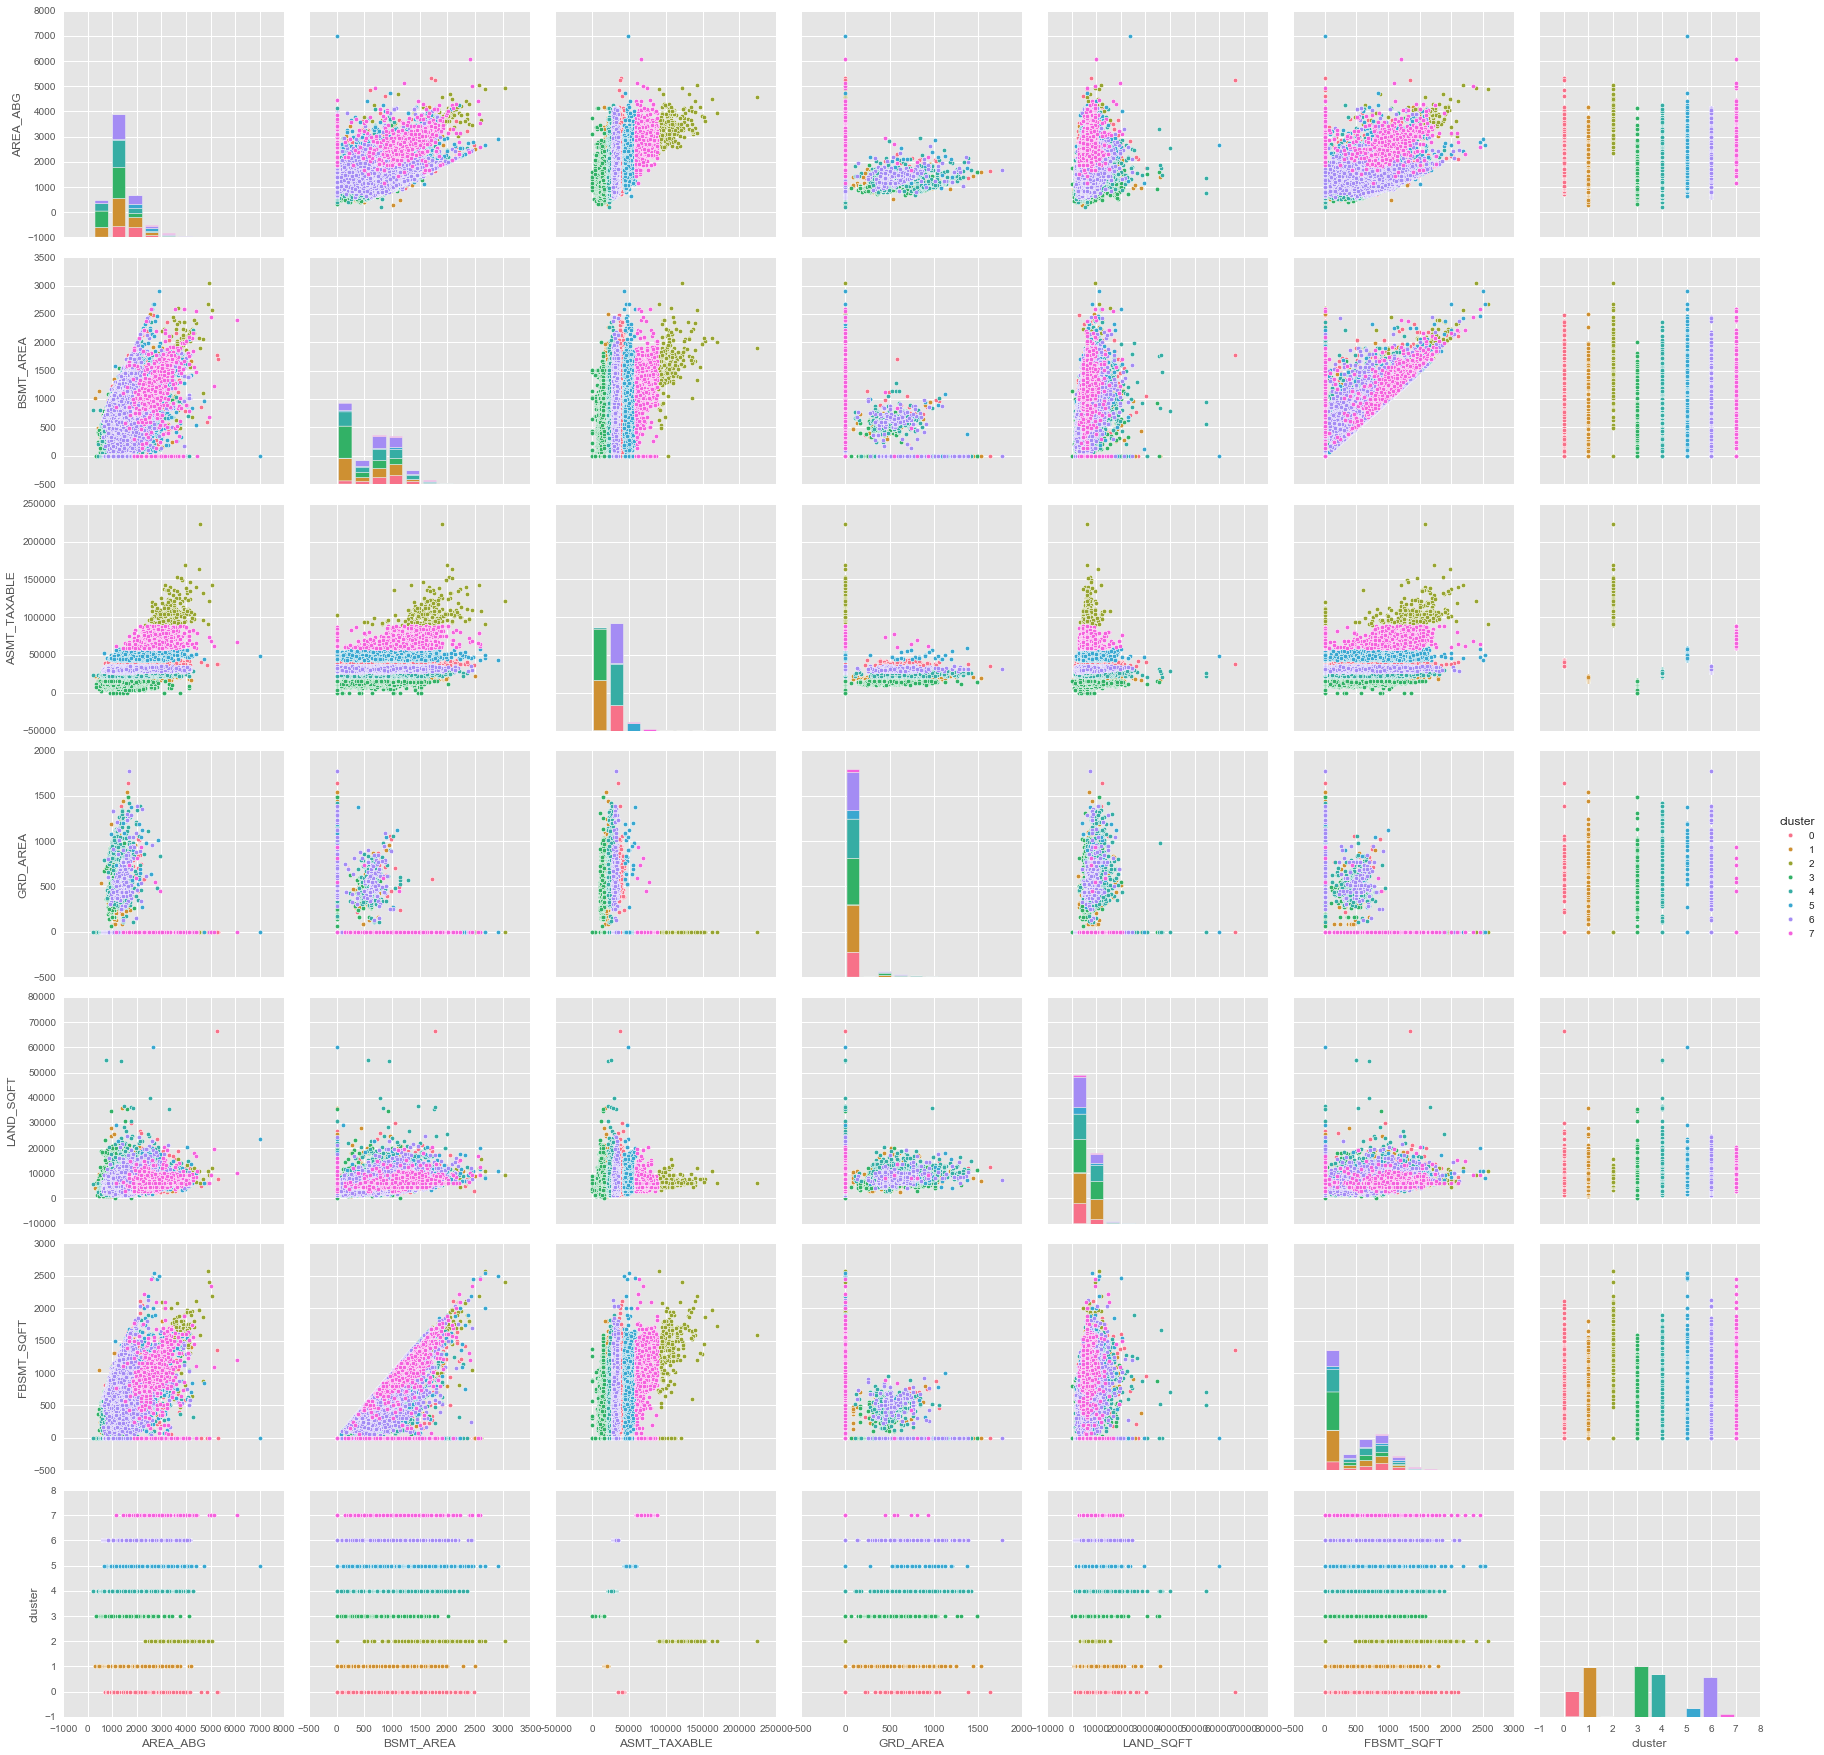

In [435]:
df_pairplot = df_full_info[['AREA_ABG', 'BSMT_AREA', 'ASMT_TAXABLE', 'GRD_AREA', 'LAND_SQFT', 'FBSMT_SQFT', 'cluster']].dropna()
sns.pairplot(df_pairplot, hue='cluster', size=3.5);

In [436]:
cluster_dummies = pd.get_dummies(df_full_info.loc[X_train.index].cluster, prefix='cluster', drop_first=True)

X_train_cluster = pd.concat([X_train, cluster_dummies], axis=1)

Now let's re-run the models to see if there's any improvement.

In [437]:
linear_model(X_train_cluster, y_train)

,R^2 Test,R^2 Train,Root Mean Squared Error
LinearRegression,0.706,0.710,57302.677


In [438]:
forest_model(X_train_cluster, y_train)

,R^2 Test,R^2 Train,Root Mean Squared Error
RandomForestRegressor,0.781,0.865,49380.182


There is modest improvement in the models, but I feel like there's more room for improvement.

In [442]:
features = ['AREA_ABG', 'BSMT_AREA', 'ASMT_TAXABLE', 'CCYRBLT', 'year', 'LAND_SQFT', 'BED_RMS', 'FULL_B', 'CCAGE_RM']

X = X_features[features]
X = pd.concat([X, month_dummies, nbhd_dummies], axis=1)

In [443]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=.33, random_state=42)

In [444]:
forest_model(X_train, y_train)

,R^2 Test,R^2 Train,Root Mean Squared Error
RandomForestRegressor,0.781,0.867,49414.531
